In [1]:
import math

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=str(other))
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
        
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=str(other))
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other
        
    def __radd__(self, other):
        return self + other
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int / float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * (other**(-1))
        
    def tanh(self):
        t= (math.exp(2*self.data)-1)/(math.exp(2*self.data)+1)
        out = Value(t, _op='tanh', _children=(self, ))
        def _backward():
            self.grad += (1 - t**2)*out.grad
            
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad    
        out._backward = _backward
        
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                visited.add(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
a = Value (2.0)
b = Value (4.0)
a/b
a - b

Value(data=-2.0)

In [5]:
from graphviz import Digraph
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build (v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # If this value is a result of some operations, create an op node for it
      dot.node(name=uid+n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid+ n._op, uid)
  for n1, n2 in edges:
    #connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [6]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.labelb = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

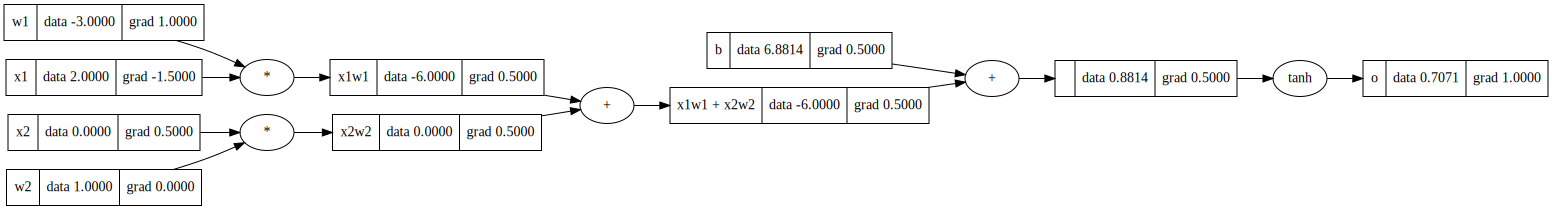

In [7]:
draw_dot(o)

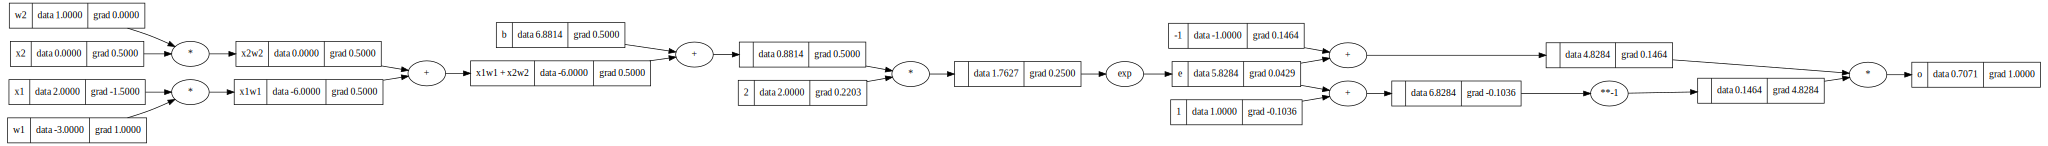

In [8]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.labelb = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [9]:
import torch

x1 = torch.Tensor([2.0]).double()                 ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                 ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                 ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()   ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('x2', w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
x2 0.0


In [41]:
class Neuron:
    ''' Neuron in a Multilayer Perceptron
        Receives nin number of input values
        Has nin number of weights, corresponding 1:1 to each input value
        Multiplies each weight with each input and sums the products(dot product)
        Add bias to give final value of the Neuron'''

    def __init__(self, nin: int):
        # Randomly initializes the weights vector
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # Randomly initializes the bias for the Neuron
        self.b = Value(random.uniform(-1, 1))
        # Value of the neuron. Helpful for backward pass.
        self.val = Value(0.0)
        self.grad = Value(0.0)

    def __call__(self, x:[]):
        # w * x + b
        # w * x is a dot product
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        #Activation function at the end of the neuron's calculation
        out = act.tanh()
        self.val = out
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    '''One Layer of the Multilayer Perceptron
       nin is number of neurons that feed into this layer.
       nout is number of neurons this layer is supposed to have
       Upon being called, does a forward pass for all neurons'''

    def __init__(self, nin: int, nout: int):
        # Creates a vector of neurons of the number nout
        # Each created neuron receives inputs from nin other Neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # Call the neurons and hence run the forward pass for each one.
        # Assembles the neurons into another list.
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    '''The Multilayer Perceptron
        nin is the number of inputs to the model
        nouts is a vector describing the size of each layer'''
    
    def __init__(self, nin, nouts):
        # Number of Neurons need in each layer (including input layer)
        sz = [nin] + nouts
        # Create the layers
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        # Call every layer and execute a forward pass
        # x is the value for the input layer
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [160]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.839978924566928)

In [161]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.839978924566928),
 Value(data=-0.7747045130044604),
 Value(data=-0.5944851196322568),
 Value(data=-0.8767521494362627)]

In [146]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.0034963044485568145)

In [144]:
loss.backward()

In [145]:
for p in n.parameters():
    p.data += -0.0001 * p.grad

In [45]:
n.layers[0].neurons[0].w[0].data

-0.6350988454086497

In [170]:
for k in range(20):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.00234788724736873
1 0.0023269106756892877
2 0.0023062984781372278
3 0.002286041317188011
4 0.0022661301702151895
5 0.0022465563163667364
6 0.0022273113240911294
7 0.0022083870392755325
8 0.0021897755739617468
9 0.002171469295607113
10 0.002153460816860283
11 0.0021357429858230217
12 0.002118308876771597
13 0.0021011517813124617
14 0.0020842651999489568
15 0.0020676428340367595
16 0.002051278578107527
17 0.002035166512541183
18 0.002019300896568442
19 0.002003676161586601


In [171]:
ypred

[Value(data=0.9860280035088882),
 Value(data=-0.9812817692015268),
 Value(data=-0.9716654063939706),
 Value(data=0.9744023806459428)]